# Energy calculation for flares in K2 lightcurves

In [127]:
#if band value == -999.0 no magnitude is given

#LATER: Add z-y from mamajek or so...
import numpy as np
import random
import pandas as pd

def import_pickles98():
    
    '''
    
    Read in the lookup table for spectral classes into a dataframe.
    
    Column names:
    spec_class, lum_class, u_g, g_r, r_i, i_z, z_J, J_H, H_K, Jmag_abs
    
    '''
    
    df = pd.read_csv('share/spectralclasses_padded.csv',skiprows=49)
    df.lum_class = df.lum_class.str.strip()
    df.spec_class = df.spec_class.str.strip()
    return df

def insert_spec_class(lookup_spec,c1,c2,index,l='V',debug=False):
    
    '''
    
    Looks up the best fitting spectral class for a given _c1_-_c2_ in color _index_ 
    within luminosity class _l_ in the _lookup_spec_ table for a given object.
    
    Return:
    
    idx: indices of best fitting rows in lookup_spec
    
    '''
    
    if c1!=-999.0 and c2!=-999.0:
        
        try:

            color = c1-c2
            lookup = lookup_spec[lookup_spec['lum_class'].str.strip() == l]
            spec_class = lookup_spec.spec_class
            color_list = lookup_spec[index]
            idx = []
            try:
                for i, row in lookup.iterrows():
                    left = color_list[i]
                    right = color_list[i+1]
                    if left < color < right:    
                        if abs(color - left) < abs(color - right):
                            idx.append(i)
                        else: idx.append(i+1)
            except IndexError:
                pass

            if len(idx) != 0:
                spec_classes = [spec_class[j] for j in idx]

            else:
                spec_classes = 'color index too high or low to be assigned'
                'to spectral class in this luminosity class'
            all_spec_classes = [spec_classes,l]

        except (KeyError, TypeError):
            idx = []
            all_spec_classes = ['None',l]
            if debug == True:            
                print('no entries for color index {}.\n'.format(index))

    else:
        idx=[]
    
    return idx


def dprint(str,debug):
    
    '''
    
    Prints out all help text snippets where the debug flag is passed.
    
    '''
    
    if debug==True:
        print(str)
    return

def display(opt,d,debug):
    
    '''
    
    Displays additional information about a resulting 
    combo _opt_ of spectral classes given some colors 
    and approximates their likelihood by the mutual distance
    between the rows _d_. Conditional on the _debug_ flag being passed.
    
    '''
    
    dprint('New combination: {}'.format(opt),debug)
    dprint('This combination has distance {}'.format(d),debug)
    
    return

def optimize_spec_class(colors,lookup_spec,debug=False):
    
    '''
    
    THIS IS A VERY LOW-LEVEL IMPLEMENTATION. FUTURE VERSION SHOULD USE PANDAS.
    
    Input:
    colors: series with J,H,K,g,r,i,z,y colors
    lookup_spec: lookup data frame with spectral and luminosity classes for different colors
    
    '''
    
    indices={'J_H':('J','H'),'H_K':('H','K'),'Jmag_abs':'J','g_r':('gmag','rmag'),'r_i':('rmag','imag'),'i_z':('imag','zmag'),'z_y':('zmag','ymag')}
    #Different luminosity classes can occur
    #luminosity_classes={'I':0.01,'III':0.,'V':-0.01}
    
    #RESTRICT TO DWARFS
    #luminosity_classes={'V':-0.01}
 
    
    #Initialize the procedure:
    lum_opt=dict()
    minspread=10000
    lum_class='V'
    best_lum_class = lum_class
    best_spec_class='None'
    opt_backup=dict()
    
    dprint('These are the given colors: \n{}\n\n'.format(colors),debug=debug)
    
    #Construct the optimum spec class solution for each luminosity class:
 #   for lum_class, weight in luminosity_classes.items():
    dprint('-------------',debug)
    dprint(lum_class,debug)

    #initialize a list that contain the indices in order to compute the uncertainty on the estimate later
    spr=[]
    #initialize the color indices that are used in the end and their respective values
    color_results={}

    #Iterate over all color indices (j,h,k or g,r,i,z,y) to compute possible colors (e.g.: j-h or r-i)
    #This yields a list of possible spectral classes for each color since colors are not 
    #an unambiguous function of spectral class, i.e. several spectral classes can share the same color index
    for key,v in indices.items():

        if key == 'Jmag_abs':
            #Same goes for luminosity only. Jmag_abs values correspond to spectral classes, too:
            #idx returns the indices into the Pickles'98 table that correspond to spec classes:
            #all of this for the given luminosity class
            c = colors.get(v)
            idx = insert_spec_class(lookup_spec,c,0,key,l='V', debug=debug)
        else:
            #unpack the colors for each color index
            v1,v2 = v
            c1 = colors.get(v1)
            c2 = colors.get(v2)
            #idx returns the indices into the Pickles'98 table that correspond to spec classes:
            #all of this for the given luminosity class
            idx=insert_spec_class(lookup_spec,c1,c2,key,l='V', debug=debug)

        #So, for a certain color index name (key) there is a list of indices (idx) that fit into the Pickles'98 table
        color_results[key]=idx


    dprint(color_results,debug)

    #Now given a dict with different colors and possible spec classes for each of them we have to find the best combination
    #This is done by finding the combination which lies closest together within the table and hence has the least uncertainty

    #Initialize the a new possible optimum, that may later become the backup solution
    opt=dict()
    #Iterate over all colors and their possible classes to find the closest entries in the other color indices
    for key, value in color_results.items():
        #remove the regarded color index to avoid redundance
        rest_results=dict(color_results)
        del rest_results[key]
        #Iterate over all possible classes (index) for the given central color (key)
        for index in value:
            #add the associated color for the central index
            opt[key]=lookup_spec.spec_class[index]
            #add central index to the list of indices that should be clostest to each other among all given indices across all colors
            spr.append(index)
            #Init distance list for linear distances
            d=[]
            #Iterate over all other colors and find the indices of possible spectral classes that are closest to the chosen cetral one
            for key2, value2 in rest_results.items():
                #compute all the linear distances
                delta=[abs(x-index) for x in value2]
                if delta!=[]:
                    #find the minimum linear distance
                    dadd=min(delta)
                    d.append(dadd)
                    #find its corresponding index in Pickles'98 table
                    minind=value2[delta.index(dadd)]
                    #add the associated color
                    opt[key2]=lookup_spec.spec_class[minind]
                    #add to the list of indices that should be closest to each other
                    spr.append(minind)

            #distance calculation
            #The row number distance within a padded table is used as proxy to uncertainty
            #distance d is defined as the sum of distances to one of the rows in n-colored space
            d=np.sqrt(sum([x*x for x in d]))/len(color_results)

            #select this iteration if it yields a minimum in distance
            try:
                if d<mindist:
                    #output for debugging
                    display(opt,d,debug)
                    mindist=d
                    opt_backup=dict(opt)
                else:
                    #output for debugging
                    display(opt,d,debug)
                    dprint('Best solution has been found already, namely: {}'.format(opt_backup),debug)
                    opt.clear()
            #This error occurs if mindist has not yet been assigned
            except UnboundLocalError:
                #output for debugging
                display(opt,d,debug)
                mindist=d
                opt_backup=dict(opt)
        mindist=0
        del mindist
        #Assign a relative spread within the best solution weighted by the number of colors
        rel_spread=np.std(np.array(spr))
        #Calculate the mean index for the resulting spectral class
        mean=np.mean(np.array(spr))
        dprint('The standard deviation for the optimum solution in this luminosity class is {}'.format(rel_spread),debug)
        #Minimize the spread across all luminosity classes
        try:
            if rel_spread < minspread:
                minspread = rel_spread
                best_lum_class = lum_class
                best_spec_class = tab_spec.spec_class[int(np.rint(mean))]
        #This error occurs if rel_spread has not yet been assigned
        except UnboundLocalError:
            minspread=rel_spread
            best_lum_class=lum_class
            best_spec_class=tab_spec.spec_class[int(np.rint(mean))]
        #Summarize the results for all luminosity classes in one dict:
        lum_opt[lum_class]=[rel_spread,opt_backup]
        
    dprint('-------------------',debug)
    dprint('Best results for spectral class and luminosity class: L={} and spec={}.'.format(best_lum_class,best_spec_class),debug)
    dprint('',debug)
    
    return best_spec_class

def import_params(cluster,basics,debug=False):
    
    loc='share/'+cluster+'/'+cluster+'_parameter.csv'
    #params=open(loc)
    #param_dict=dict()
    #basics=params.readline()
    #basics=[u for u in basics[1:-2].split(', ')]

    
#     with open(loc) as params:
#         basics=params.readline()
#         basics=[u for u in basics[1:-2].split(', ')]
        
    params=pd.read_csv(loc)
    params['results']=pd.Series('NaN')
    
    if debug == True:
        print('These are the parameters from the matching procedure\n\n{}\n'.format(params.head()))

    return params, basics

def optimize_spec_class_ID(oid,param_dict,tab_spec,debug=False):

    param_dict.set_index('EPIC',inplace=True)
    #ID,c_idx = param_dict.ID[oid], param_dict.color_set[oid]
    #c_idx = param_dict.color_set[oid]
    #colors = param_dict[list(param_dict.color_set[oid])].loc[oid]
    bsc = optimize_spec_class(param_dict.loc[oid],tab_spec,debug=True)
    
    return bsc

def optimize_spec_class_all(param_dict, tab_spec, debug=False):
    
    for index, row in param_dict.iterrows():
        #blc,bsc,lum_opt=optimize_spec_class(row[list(row['color_set'])],tab_spec,c_idx=row['color_set'],debug=debug)
        bsc=optimize_spec_class(row,tab_spec,debug=debug)
        param_dict.results[index] = bsc
        
    return param_dict

## Here I test the pipeline for a single LC in Ruprecht 147, ID=219652181:

In [128]:
tab_spec = import_pickles98()
cluster_dict = {'M67':['M67','M67', 15, 4.0],
                'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                'M45':['M45','M45',55.,0.12,120.]
               }

#calculate distance modulus for cluster
cluster = 'M67'
params, basics = import_params(cluster, cluster_dict[cluster],debug=True)
DM = lambda x: 5.*np.log10(float(x))-5. 
dm = DM(basics[3])
global dm

optimize_spec_class_ID(211395699,params,tab_spec,debug=False)

These are the parameters from the matching procedure

   Unnamed: 0       EPIC  RAJ2000_K2  DEJ2000_K2       J       H       K  \
0           0  228682441  132.877458   11.815250     NaN     NaN     NaN   
1           1  211410963  132.621046   11.806506  16.039  15.386  15.462   
2           2  211411112  132.612450   11.808697  12.177  11.903  11.829   
3           3  211416648  132.619529   11.891700  14.653  14.113  13.941   
4           4  211396422  132.874708   11.586428  11.620  11.366  11.317   

       Kp       UCAC4             2MASS   ...     zFlags     ymag  e_ymag  \
0  13.310         NaN               NaN   ...      32804  12.9885  0.0088   
1  18.602         NaN  08502905+1148234   ...     115000  17.2755  0.0024   
2  13.405  510-048372  08502698+1148313   ...     115000  13.0373  0.0049   
3  16.425  510-048375  08502868+1153300   ...     115000  15.6877  0.0031   
4  12.695  508-049252  08512993+1135112   ...      98340  12.4603  0.0021   

     yKmag  e_yKmag  yFlag

'G2'

## If the test works, try to process the entire cluster with the function defined below

In [129]:
specs=optimize_spec_class_all(params,tab_spec,debug=False)
#print(specs.head())

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.or

## Plot the results!

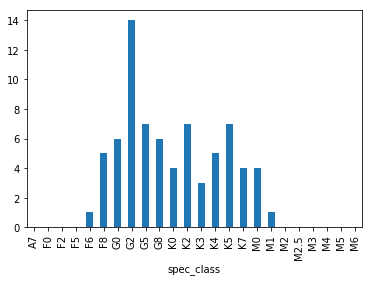

In [119]:
%matplotlib inline

counts = specs.results.value_counts()
y = counts[x][11:]

plot = y.plot(kind = 'bar')
fig = plot.get_figure()
fig.savefig('docs/{}/{}_spec_Kp.jpg'.format(cluster,cluster),dpi=300)



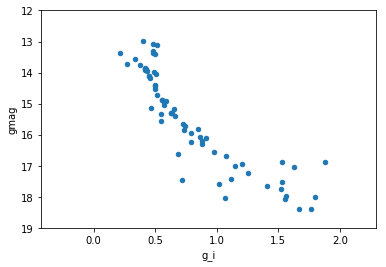

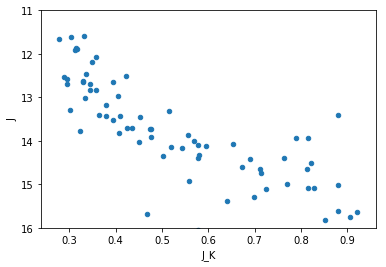

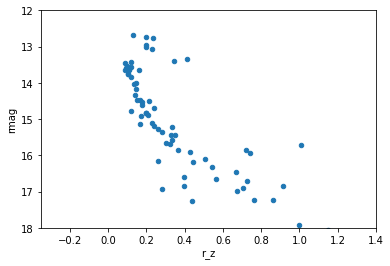

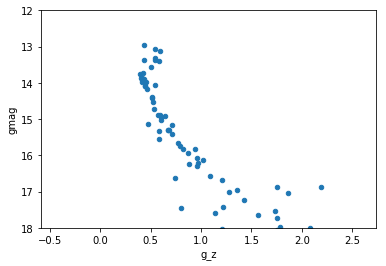

In [120]:
#%matplotlib inline



def CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5)):
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,kind = 'scatter')
    fig = plot.get_figure()
    fig.savefig('docs/{}/{}_CMD_{}.jpg'.format(cluster,cluster,color),dpi=300)
    return

CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,12))#19,5
CMD(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(16,11))#14,5
CMD(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(18,12))#18,5
CMD(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(18,12))#18,5


## Calculate energies

In [32]:
from scipy.constants import pi, h, c, k
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import specmatchemp.library
import specmatchemp.plots as smplot


h*=1e7 # Planck constant in erg*s
c*=1e2 # light speed in cm/s
k*=1e7 # Boltzmann constant in erg/K

#Solution to nan-bug:
#https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return

#End: Solution to nan_bug

def spectrum(T,wavmin=3480., wavmax=9700.):
    
    '''
    
    Returns the spectrum of a star at effective temperature T in wavelength range [wavmin,wavmax]
    Default range corresponds to Kepler response
    
    '''
    #loads library of spectra within wavelength range
    lib = specmatchemp.library.read_hdf(wavlim=[wavmin,wavmax])
    #find the spectrum that fits T best
    Tmin = str(T-50.)
    Tmax = str(T+50.)
    cut = lib.library_params.query(Tmin+'<Teff<'+Tmax)    
    T_offer = zip(list(cut['Teff']), list(cut['lib_index']))
    T_minindex = min(T_offer, key = lambda t: abs(t[0]-T))[1]
    cut = cut.loc[T_minindex]
    #return the spectrum
    spec = lib.library_spectra[cut.lib_index,0,:]
    return lib.wav, spec.T

def kepler_spectrum(T):
    '''
    
    Convolves a blackbody of effective temperature T, 
    the spectrum of a dwarf star with corresponding spectral class,
    and the Kepler response function 
    to return the wavelength dependent flux of that star per area
    
    Input:
    T - effective temperatur in K
    
    Returns:
    Kp_flux in erg/cm*(cm**2)
    Kp_midwav in 
    
    
    '''
    Kp_wav, Kp_resp = np.loadtxt('spectra/Kepler_response.txt',unpack=True)
    Kp_wav*=10. #convert to angström for spectrum function
    #load the spectrum within a wavelength range that fits given T_eff best
    Spec_wav,Spec_flux = spectrum(T,min(list(Kp_wav)),max(list(Kp_wav)))
    #map Kepler response linearly into wavelengths given with the spectrum
    Spec_flux = np.interp(Kp_wav,Spec_wav,Spec_flux)
    Kp_flux = np.empty(len(Kp_wav)-1)
    Kp_midwav  = np.empty(len(Kp_wav)-1)
    #calculate the flux of a star with given T_eff 
    #accounting for Kepler filter 
    #and the corresp. spectrum of that stellar type 
    try:
        for i, response in enumerate(Kp_resp):
            dlambda = (Kp_wav[i+1]-Kp_wav[i])*1e-8 #infin. element of wavelength in cm
            lambda_ = np.mean(Kp_wav[i:i+2])*1e-8 #wavelength in cm
            Kp_midwav[i] = lambda_

            Kp_flux[i] = Spec_flux[i] *response* 2. * h * c**2 / lambda_**5 / (np.exp(h * c / ( lambda_ * k * T ) ) - 1. ) 
            
    except IndexError:
        pass
    
    return Kp_midwav, Kp_flux

def plot_kepler_spectrum(T):

    wav,flux = kepler_spectrum(T)
    plt.figure()
    plt.plot(wav*1e8, flux,color='green')
    plt.show()
    
    return


    

def kepler_luminosity(T):
    
    '''
    Integrates the Kepler flux,
    multiplies by the area A=pi*(R**2),
    to obtain observed quiescent flux for an object
    
    Return:
    
    total Kepler luminosity in erg/s of a dwarf star with effective temperature T
    
    '''
    
    params=pd.read_csv('share/spec_class_Teff_mamajek.txt')
    
    #calculate Kepler spectrum of a dwarf star with temperature T
    wav,flux=kepler_spectrum(T)
    
    #interpolate where nans occur
    interpolate_nan(wav)
    interpolate_nan(flux)
 
    #select the relevant columns from params
    radii_teff=params[['Teff','R_Rsun']]
    
    #find the entry in radii_teff which lies closest in terms of tempererature to T
    Tmin=min([abs(x-T) for x in radii_teff.Teff])+T
    
    #set index of data frame to be T_eff
    radii_teff.set_index('Teff',inplace=True)

    #select the radius of the given star with T_eff
    try:
        radius_cm=radii_teff.R_Rsun[Tmin]*6.96342e10 #stellar radius in cm
    except KeyError:
        radius_cm=radii_teff.R_Rsun[2.*T-Tmin]*6.96342e10 #stellar radius in cm

    return np.trapz(flux, wav)*pi*(radius_cm**2)

kepler_luminosity(6340.)

Reading library from /home/ekaterina/.specmatchemp/library.h5


2.2244596022786706e+32

In [34]:
def spec_class_to_Teff(s):
    params=pd.read_csv('share/spec_class_Teff_mamajek.txt')
    #set index of data frame to be T_eff
    params.set_index('Teff',inplace=True)
    #find and return the T_eff that correspods to the given spectral class:
    try:
        return params[params.dwarf==s].index.values[0]
    except IndexError:
        return None
spec_class_to_Teff('M1')

3700

In [36]:
import pandas as pd
cluster = 'M44'
df = pd.read_csv("cats/" + cluster + "_k2_search.txt",
                 #delimiter='\t',
                 header=0, 
                 usecols=['K2 ID','KEP Mag','Kep Flag'],
                 skiprows=[1],
                )
df.rename(index=int,columns={'K2 ID' : 'EPIC','KEP Mag':'Kp','Kep Flag':'KEP_Flag'},inplace=True)

def Kp_to_Lum(df, dm, Kp='Kp'):
    df['Kp_abs'] = df[Kp]+dm
    print(df.head())
    return

Kp_to_Lum(specs,7,Kp=)

        EPIC      Kp KEP_Flag  Kp_abs
0  211960587  11.992      gri  18.992
1  211959779  11.796      gri  18.796
2  211968598  14.817      gri  21.817
3  211968228  15.213      gri  22.213
4  211958885  18.195      JHK  25.195


# Plotting the flare frequency as a function of ED for by-hand analysis


In [39]:
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt

def ED(start,stop,time,flux_model,flux_gap):
    time = time[start:stop+1]
    model = flux_model[start:stop+1]
    flux = flux_gap[start:stop+1]
    residual = np.subtract(flux,model)
    flare = trapz(residual,time)
    quiet = trapz(model,time)
    ed = flare/quiet
    return ed


def import_flares(cluster, oid):
    
    objectid = str(oid)
    loc = 'share/' + cluster + '/' + cluster + '_post_appa/' + objectid
    myloc = loc + '_my_flares.txt'
    try:
        myflares = pd.read_csv(myloc, names= ['start','stop','istart','istop','comment'])
        print(myflares.head())
    except OSError:
        print('No by hand analysis available.')
        myflares = []
    appaloc = loc + '.txt'
    appaflares = pd.read_csv(appaloc, names= ['time','flux_gap','error','flux_model'])
    print(appaflares.head())
    appaidsloc = loc +'_flares.txt'
    appaids = pd.read_csv(appaidsloc, names= ['istart','istop'])
    print(appaids.head())
    
    return myflares, appaflares, appaids


cluster='M44'
oid = 219519432
#objectid = str(oid)
myflares, appaflares, appaids = import_flares(cluster, oid)
param_dict, basics = import_params()
best_lum_class,best_spec_class,lum_opt = optimize_spec_class_ID(oid,param_dict)
T = float(spec_class_to_Teff(best_spec_class))
print(T)

L_quiet = kepler_luminosity(T)
print('The quiescent Kepler luminosity for this spectral class is {}.'.format(L_quiet))

         start         stop  istart  istop comment
0  2468.629628  2468.670493      67     69      ne
1  2468.874816  2468.915681      79     81      ne
2  2472.062255  2472.103120     235    237      ne
3  2472.797817  2472.838681     271    273      ne
4  2473.533377  2473.574241     307    309      ne
          time       flux_gap     error     flux_model
0  2467.260659  284751.859332  20.13988  307326.209982
1  2467.281092  284061.644626  20.13988  307326.579803
2  2467.301524  282392.570460  20.13988  307326.787138
3  2467.321957  281486.713185  20.13988  307326.860922
4  2467.342389  279970.488875  20.13988  307326.830084
   istart  istop
0     233    236
1     384    386
2     425    428
3     698    702
4     901    905


TypeError: import_params() missing 2 required positional arguments: 'cluster' and 'basics'

### pandas.panel:

233
384
425
698
901
1000
1253
1285
1450
1696
1761
1771
1837
2146
2331
2917
3121
3577
4023
[32.200250885844085, 32.72972510503282, 32.23740352109219, 32.298588195907996, 32.086359145670919, 32.279985188555308, 32.123767937311428, 32.362426458079717, 32.316562423231638, 32.802256020137847, 32.120938189069939, 32.401211270840903, 32.241524567840806, 32.214029200483715, 32.260349276170494, 32.326305824219077, 32.306200887329013, 32.356768713181616, 32.252020567085601]
[ 5 11  1  0  2]
[19 14  3  2  2]


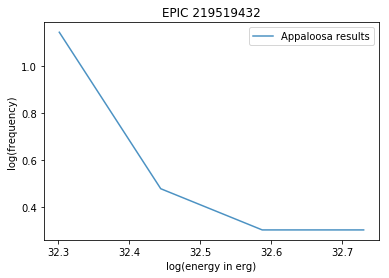

In [9]:
def cum_hist(flareids, appaflares, L_quiet,bins=5):
    ED_=[]
    for i,row in flareids.iterrows():
        print(row['istart'])
        ed = ED(row['istart'],row['istop'],appaflares.time,appaflares.flux_model,appaflares.flux_gap)
        ED_.append(np.log10(ed*24.*60.*60.*L_quiet))

    hist, edges=np.histogram(ED_, bins=bins)

    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    return hist, edges
    
#histmy, edgesmy = cum_hist(myflares, appaflares, L_quiet,bins=5)
histAppa, edgesAppa = cum_hist(appaids, appaflares, L_quiet,bins=5)

#bin_edges_help = edgesmy[1:]
bin_edges_help = edgesAppa[1:]
edgesmy = edgesAppa
binmids=[(x+edgesmy[i])/2. for i,x in enumerate(bin_edges_help)]

plt.figure()
plt.title('EPIC '+objectid)
#plt.plot(binmids[1:],np.log10(histmy[1:]),alpha=0.8,color='red',label='By hand analysis')
plt.plot(binmids[1:],np.log10(histAppa[1:]),alpha=0.8,label='Appaloosa results')

plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
plt.show()

#def plot_CFFD(panel, objectid):
    
#plt.savefig('results/'+objectid+'_byhand_vs_Appaloosa.png')

In [28]:
T = specs.to_frame()

T['T']=[spec_class_to_Teff(s.results) for i,s in T.iterrows()]

T.head()

T.to_csv('cats/' + cluster + '_specs_T.csv')

In [29]:
tab_spec = import_pickles98()

#calculate distance modulus for cluster
param_dict, basics = import_params(cluster='M44')
DM = lambda x: 5.*np.log10(float(x))-5. 
dm = DM(basics[3])
global dm

optimize_spec_class_ID(219753819,param_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'share/cross_match/union/M44_parameter.txt'